#Importing the Libraries and Files

In [ ]:
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model, pad_sequences
from tensorflow.keras import layers
from google.colab import files, drive
from time import time
import pandas as pd
import re
import gc
import random
import numpy as np
from tensorflow.data import Dataset, AUTOTUNE
import tensorflow as tf

In [ ]:
if "kaggle.json" not in os.listdir():
  files.upload()
  !pip install kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d nunenuh/flickr30k
  !unzip -q /content/flickr30k.zip

In [ ]:
features = {}
feature_fileloc = "features-extracted.pkl"
start_time = time()
if feature_fileloc not in os.listdir():
  img_path = "/content/images/flickr30k_images/"
  dir_files = os.listdir(img_path)
  tot_files = len(dir_files)

  effnet = tf.keras.applications.EfficientNetB0()
  feature_extractor = Model(inputs=effnet.inputs,
                            outputs=effnet.layers[-2].output)

  for _ in range(tot_files - 25000):
    dir_files.remove(random.choice(dir_files))
  gc.collect()
  tot_files = 25000

  for img_no, img_name in enumerate(dir_files):
    img = image.load_img(img_path + img_name,
                        target_size=(224, 224))
    img = image.img_to_array(img)
    img_arr = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    feat_extracted = feature_extractor.predict(img_arr,
                                  verbose=0)
    features[img_name] = feat_extracted
    if (img_no + 1) % 200 == 0:
      passed = time() - start_time
      eta = passed * (tot_files/img_no - 1)
      print(f"{img_no+1} of {tot_files} Time Passed: {passed: .2f} ETA: {eta: .2f}")

  with open(feature_fileloc, "wb") as feature_file:
    pickle.dump(features, feature_file)
  del features
  gc.collect()
else:
  with open(feature_fileloc, "rb") as feature_file:
    features = pickle.load(feature_file)

In [ ]:
df = pd.read_csv("/content/captions.txt", sep="|")
df = df[df.image_name.isin(features.keys())]

In [ ]:
def clean(text):
  text = text.lower()
  text = re.sub(r"[^a-z ]", "", text)
  text = re.sub(r"\s+", " ", text)
  text = "<startseq> " + text + " <endseq>"
  return text

df["caption_text"] = df.caption_text.map(clean)

In [ ]:
captions = {}
for i, row in df.iterrows():
  if row.image_name not in captions:
    captions[row.image_name] = [row.caption_text]
  else:
    captions[row.image_name].append(row.caption_text)

In [ ]:
corpus = []
for v in captions.values():
  corpus += v

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)
voc_size = len(tokenizer.word_index) + 1
voc_size

17951

#Splitting the data into train, validation and test sets

In [ ]:
img_files = features.keys()
tot_files = len(img_files)

In [ ]:
def split_data(data_size):
  img_no = 0
  data = set()
  while img_no < data_size:
    new_img = random.choice(list(img_files))
    if new_img not in data:
      data.add(new_img)
      img_no += 1
  return data

In [ ]:
train_size = int(0.9 * tot_files)

train_data = split_data(train_size)
val_data = img_files - train_data

train_data = list(train_data)
val_data = list(val_data)

#Creating data generator to load the data in batches

In [ ]:
maxlen = max(len(caption.split()) for caption in corpus)

In [ ]:
def gen_batches(data_keys, mapping,
                features, tokenizer,
                max_length, vocab_size,
                batch_size):
  x_img, x_text, y = [], [], []
  n = 0
  while True:
    for key in data_keys:
      n += 1
      img_captions = mapping[key]
      for caption in img_captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(len(seq)):
          context, future = seq[:i], seq[i]

          context = pad_sequences([context],
                                  maxlen=maxlen)[0]
          future = to_categorical([future],
                                  num_classes=voc_size)[0]

          x_img.append(features[key][0])
          x_text.append(context)
          y.append(future)

      if n==batch_size or key==len(data_keys):
        x_img, x_text, y = np.array(x_img), np.array(x_text), np.array(y)
        yield [x_img, x_text], y
        x_img, x_text, y = [], [], []
        n = 0

#Creating the model

## encoder

### image encoder

In [ ]:
input_img = layers.Input(shape=(1280,))
img_encoder = layers.Dropout(0.4)(input_img)
img_encoder = layers.Dense(256, activation="relu")(img_encoder)

### text encoder

In [ ]:
input_seq = layers.Input(shape=(maxlen, ))
seq_encoder = layers.Embedding(voc_size, 256,
                               mask_zero=True)(input_seq)
seq_encoder = layers.Dropout(0.5)(seq_encoder)
seq_encoder = layers.LSTM(256)(seq_encoder)

## decoder

In [ ]:
decoder = layers.add([img_encoder, seq_encoder])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(voc_size,
                      activation="softmax",
                      name="next_word_layer")(decoder)

## Combining and Compiling

In [ ]:
model = Model(inputs=[input_img, input_seq],
              outputs=output,
              name="ImageCaptioner")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
model.summary()

Model: "ImageCaptioner"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1280)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 256)              4595456   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1280)                 0         ['input_1[0][0]']             
                                                                                     

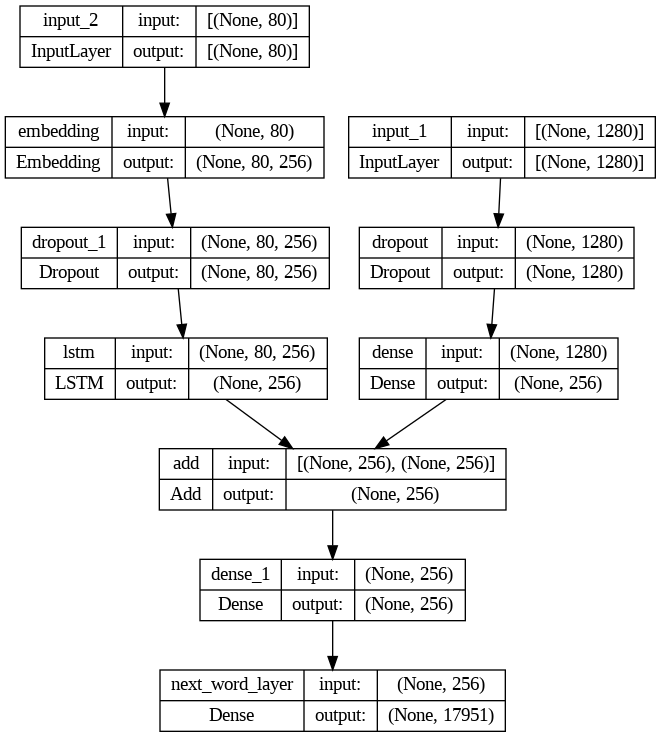

In [ ]:
plot_model(model,
           show_shapes=True)

##Training the model

In [ ]:
epochs = 20
batch_size = 32
epoch_steps = len(train_data)//batch_size

In [ ]:
train_gen = gen_batches(train_data, captions, features,
                        tokenizer, maxlen, voc_size, batch_size)
val_gen = train_gen = gen_batches(val_data, captions, features,
                        tokenizer, maxlen, voc_size, batch_size)

In [ ]:
for i in range(epochs):
  model.fit(train_gen,
            epochs=1,
            steps_per_epoch=epoch_steps)
  gc.collect()

444/703 [=================>............] - ETA: 2:38 - loss: 0.6359

In [ ]:
model.save("image_captioner.keras")

In [ ]:
model = load_model("/content/image_captioner.keras")

In [ ]:
with open("tokenizer.pkl", "wb") as tokenizer_file:
  pickle.dump(tokenizer, tokenizer_file)

In [ ]:
with open("tokenizer.pkl", "rb") as tok_file:
  tokenizer = pickle.load(tok_file)

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

def gen_caption(model, img_path, tokenizer, max_length):
  text = "<startseq>"
  img = image.load_img(img_path,
                        target_size=(224, 224))
  img = image.img_to_array(img)
  img_arr = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  feat_extracted = feature_extractor.predict(img_arr,
                                 verbose=0)

  for i in range(max_length):
    seq = tokenizer.texts_to_sequences([text])[0]
    seq = pad_sequences([seq], max_length)[0]
    y_pred = np.argmax(model.predict([feat_extracted, np.array([seq])],
                                     verbose=0))
    word = tokenizer.sequences_to_texts(np.array([[y_pred]]))[0]
    if not word or word == "endseq":
      break
    text += " " + word
  plt.imshow(Image.open(img_path))
  plt.axis("off")
  plt.suptitle(" ".join(text.split()[1:]))
  # return " ".join(text.split()[1:])

In [ ]:
effnet = tf.keras.applications.EfficientNetB0()
feature_extractor = Model(inputs=effnet.inputs,
                            outputs=effnet.layers[-2].output)

In [ ]:
gen_caption(model, "/content/images/86132021.jpg", tokenizer, 80)

In [ ]:
df[df.caption_text.str.contains("naked")]